참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 40.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 11.2 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=374aa89fbd884d3be6938d3fe9e546fa1ce3feaccf962f7eb9b8b9c3c5a4a676
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1135k      0  0:00:01  0:00:01 --:--:-- 1135k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [ ]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
# 감성 분석을 위한 라벨링
# 3점도 부정 아닌가..?
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [ ]:
train_data['label'].value_counts()

,count
label,
1,80003
0,79923


### 데이터 정제 및 전처리

In [ ]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

<ipython-input-8-b3393058b13d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)
<ipython-input-8-b3393058b13d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

### 토큰화

In [ ]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/Colab Notebooks/KUBIG-NLP/1주차/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

토큰화된 data(한글로 표현되어 있음)을 `tokenizer`을 통해 숫자로 표현하는 과정으로, 긍정인지 부정인지 역시 숫자로 표현한다!

In [ ]:
train_data['label'][0:10]

,label
132466,0
188461,0
124757,1
50357,0
137655,1
25326,0
187446,1
104528,0
52897,0
178306,0


In [ ]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
train_data['tokenized'][0:10]

,tokenized
132466,"[바디, 버든, 줄이, 려고, 써, 보, 려고, 샀, 는데, 음용, 할, 수, 잇,..."
188461,"[시중, 판매, 는, 건, 새, 우랑, 다르, 게, 속살, 고루, 분포, 된, 게,..."
124757,"[깔끔, 니, 이쁘, 네요, 좋]"
50357,"[사이즈, 미스, !, 남자, 쓰, 기, 엔, 너무, 작, 네요]"
137655,"[좋, 은, 상품, 빠르, 고, 안전, 한, 배송, 감사, 합니다]"
25326,"[같, 은, 상품, 젤, 착한, 가격, 라, 굳, .]"
187446,"[더블, 하트, 젤, 잘, 된다고, 해서, 출산, 준비물, 샀어요, ^^]"
104528,"[탄력, 없, 안, 좋, 음]"
52897,"[예뻐요, 좋, 아요, 쓰, 니, 편해요]"
178306,"[닦, 아도, 닦, 아도, 연마제, 너무, 심하, 게, 나와요, ., 키친, 타올,..."


In [ ]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
len(X_train)
print(X_train[0:10])
print(y_train[0:10])

[[1929, 23114, 3029, 146, 125, 46, 146, 69, 10, 10883, 65, 79, 240, 7, 154, 15049, 28, 52, 5532, 33, 260, 76], [2272, 480, 7, 139, 297, 9465, 344, 16, 10115, 6359, 13195, 206, 16, 59, 425, 151, 229, 3, 10115, 659, 3804, 76, 13, 53, 1130, 538, 26, 230, 3, 24, 370, 28, 1400, 262, 4], [128, 63, 194, 4, 6], [68, 2712, 25, 778, 33, 31, 174, 19, 74, 4], [6, 9, 93, 72, 3, 1603, 20, 18, 101, 26], [21, 9, 93, 574, 1566, 54, 59, 535, 2], [2860, 2950, 574, 12, 1152, 37, 1694, 4044, 401, 86], [2467, 35, 15, 6, 75], [277, 6, 11, 33, 63, 358], [405, 569, 405, 569, 5405, 19, 380, 16, 905, 2, 4263, 2375, 417, 91, 16, 405, 39, 3, 148, 9, 405, 27, 40, 7659, 40, 649, 9, 23, 95, 2, 1708, 131, 62, 69, 10, 106, 62, 2713, 8462, 16, 12, 242, 28, 13, 22, 34, 11, 2]]
[0 0 1 0 1 0 1 0 0 0]


### 패딩




In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


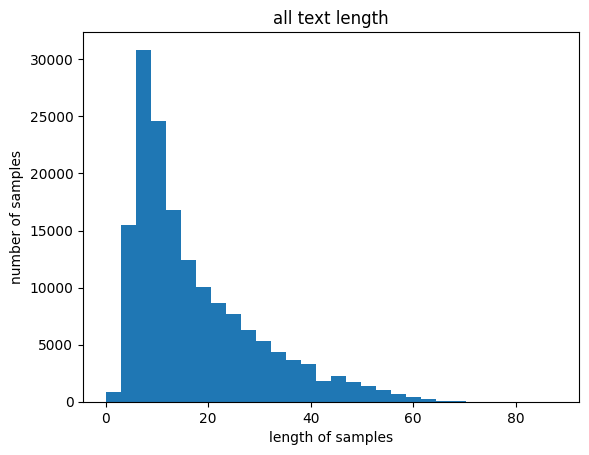

In [ ]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [ ]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 퀴즈

문제: 패딩을 하는 이유는 무엇일까요? (어떤 경우에 사용하는지 생각해보세요)

답변: 모델이 일정한 길이의 입력을 처리할 수 있도록 만들기 위해서이다. 대부분의 모델의 경우 입력의 크기가 같아야하는데, 각 리뷰에서의 토큰의 수가 달라지게 되므로 이를 고정시켜야만 제대로 학습이 가능하다. 또한 문장이 너무 길게 될 경우 긴 문장에 포함된 정보를 처리하는데 어려움을 겪을 수 있기 때문에 패딩을 사용하게 된다.

이를 `pad_sequence`를 통해 **maxlen보다 길면 뒤에 단어들을 짤라내고, 더 짧으면 0 또는 다른 패딩 값으로 채운다**

In [ ]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [ ]:
num_epoch = 10
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()

In [60]:
iter = 0
loss_list=[]
accuracy_list=[]
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            loss_list.append(loss.item())
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.6347789168357849. Accuracy: 65.7821044921875
Iteration: 1000. Loss: 0.6843892931938171. Accuracy: 71.86233520507812
Iteration: 1500. Loss: 0.5088202357292175. Accuracy: 79.44325256347656
Iteration: 2000. Loss: 0.31713438034057617. Accuracy: 81.19904327392578
Iteration: 2500. Loss: 0.43309682607650757. Accuracy: 82.51713562011719
Iteration: 3000. Loss: 0.353389173746109. Accuracy: 83.2474594116211
Iteration: 3500. Loss: 0.4650210440158844. Accuracy: 84.36796569824219
Iteration: 4000. Loss: 0.3978683650493622. Accuracy: 84.86819458007812
Iteration: 4500. Loss: 0.36817413568496704. Accuracy: 85.33340454101562
Iteration: 5000. Loss: 0.34787222743034363. Accuracy: 84.80316162109375
Iteration: 5500. Loss: 0.29962819814682007. Accuracy: 86.29132843017578
Iteration: 6000. Loss: 0.4929541349411011. Accuracy: 86.73653411865234
Iteration: 6500. Loss: 0.37390953302383423. Accuracy: 87.126708984375
Iteration: 7000. Loss: 0.24638989567756653. Accuracy: 87.30928802490234
Itera

In [61]:
print('average accuracy: {}'.format(sum(accuracy_list)/len(accuracy_list)))
print('Final 5 average accuracy: {}'.format(sum(accuracy_list[-5:])/5))
print('Final 10 average accuracy: {}'.format(sum(accuracy_list[-10:])/10))

average accuracy: 87.23114776611328
Final 5 average accuracy: 90.16007232666016
Final 10 average accuracy: 90.0827865600586


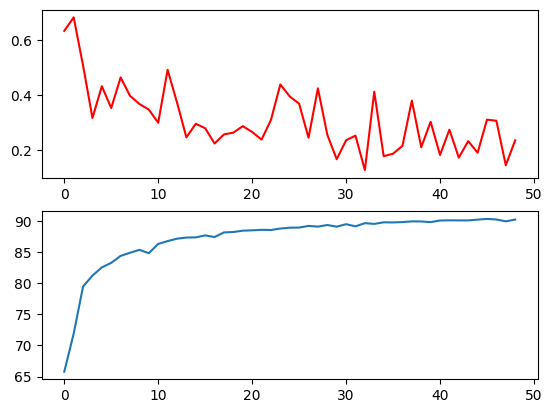

In [62]:
import seaborn as sns
accuracy_list = [acc.cpu().numpy() for acc in accuracy_list]

plt.subplot(2,1,1)
plt.plot(loss_list,label='loss',color='r')
plt.subplot(2,1,2)
plt.plot(accuracy_list, label='accuracy')

baseline code대로 돌릴 경우 loss가 일정하게 줄어들지 않고 커졌다가 작아지는 것을 확인할 수 있었다. 또한 전체적인 정확도 역시 학습이 진행할 수록 떨어지는 것을 확인할 수 있었다 전체 평균 정확도와 마지막 10개의 정확도의 평균의 차이가 크지 않는 것을 보아 hyperparameter의 수정이 필요하다는 것을 확인할 수 있었다.(epoch의 수를 줄이는 것이 필요 + learning_rate의 값을 바꿔야할듯)

또한 loss가 계속해서 줄어들지 않고, **정확도 역시 계속 떨어지는 것을 보면 과적합이 일어나지 않고 학습에 문제가 있다는 것을 확인**할 수 있다

- 15 / 0.005 => 89.6
- 5 / 0.001 => 90.6 : accuracy가 계속 증가하지만 loss가 일정하게 줄어들지는 않음:
- 5 / 0.0005 => 90.4 accuracy가 계속해서 증가 loss는 조금씩 감소하는 것을 확인
- 10 / 0.0001 => 90.1 accuracy 계쏙 증가 loss는 왔다갔다하지만 감소하는 추세

결론: **hyperparameter을 바꿔 학습을 진행하더라도 90.6의 정확도를 가지며 loss 그래프를 확인해보면 제대로된 학습을 하고 있는지 정확히 알기 힘들다.**

### 모델학습 (LSTM, Long short term memory)

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [70]:
num_epoch = 7
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005)

criterion = nn.CrossEntropyLoss()

In [71]:
iter = 0
loss_list=[]
accuracy_list=[]
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total
            loss_list.append(loss.item())
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.32150566577911377. Accuracy: 86.91911315917969
Iteration: 2000. Loss: 0.192464679479599. Accuracy: 88.79496002197266
Iteration: 3000. Loss: 0.22338953614234924. Accuracy: 90.00800323486328
Iteration: 4000. Loss: 0.16311828792095184. Accuracy: 90.50072479248047
Iteration: 5000. Loss: 0.17263689637184143. Accuracy: 90.71332550048828
Iteration: 6000. Loss: 0.17584146559238434. Accuracy: 91.2260513305664
Iteration: 7000. Loss: 0.18793776631355286. Accuracy: 91.26856994628906
Iteration: 8000. Loss: 0.17967714369297028. Accuracy: 91.2210464477539
Iteration: 9000. Loss: 0.21208195388317108. Accuracy: 91.62123107910156
Iteration: 10000. Loss: 0.18284067511558533. Accuracy: 91.68875885009766
Iteration: 11000. Loss: 0.10176559537649155. Accuracy: 91.57120513916016
Iteration: 12000. Loss: 0.2901214361190796. Accuracy: 91.55870056152344
Iteration: 13000. Loss: 0.0755021870136261. Accuracy: 91.70626831054688
Iteration: 14000. Loss: 0.15049120783805847. Accuracy: 91.62373352

In [72]:
print('average accuracy: {}'.format(sum(accuracy_list)/len(accuracy_list)))
print('Final 5 average accuracy: {}'.format(sum(accuracy_list[-5:])/5))
print('Final 10 average accuracy: {}'.format(sum(accuracy_list[-10:])/10))

average accuracy: 90.92445373535156
Final 5 average accuracy: 91.72477722167969
Final 10 average accuracy: 91.62847900390625


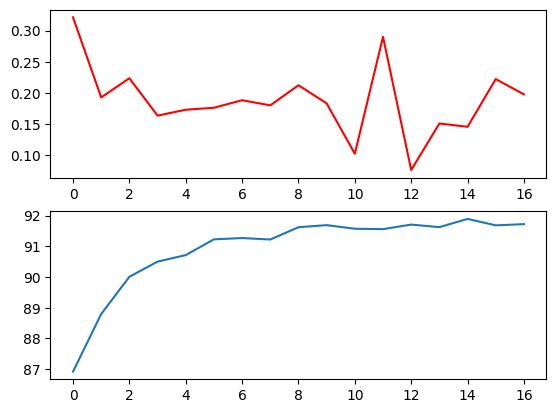

In [73]:
import seaborn as sns
accuracy_list = [acc.cpu().numpy() for acc in accuracy_list]

plt.subplot(2,1,1)
plt.plot(loss_list,label='loss',color='r')
plt.subplot(2,1,2)
plt.plot(accuracy_list, label='accuracy')

baseline model을 보게 될 경우 accuracy는 우상향하는 추세를 보이고 loss의 경우는 왔다갔다하는 모습을 보인다. 단순한 성능에서 Vanila RNN보다 높은 정확도를 보이지만 loss가 일정하게 줄어들지 않기 때문에 hyperparameter을 바꿔봐야할 여지가 있다.

- 15  / 0.005: 90.8 / 91.1
- 7 / 0.001: 91.1 / 91.3 : accuracy가 증가하다가 줄기 떄문에 learning rate를 더 줄여봐야겠음
- 7 / 0.0005: 90.9 / 91.7: acurracy가 일정 / loss가 나름 일정하게 유지된 것을 보아 학습이 어느정도 완료된 것을 확인할 수 있다.

결론: 정확도가 91.7정도까지 나오고 loss의 변화 역시 큰 편이 아니여서 Vanila RNN에 비해 성능이 좋은 것을 확인할 수 있다.

### 모델 학습 (Gated Recurrent Unit (GRU))

In [ ]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [81]:
num_epoch = 7
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005)

criterion = nn.CrossEntropyLoss()

In [82]:
iter = 0
loss_list=[]
accuracy_list=[]
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total
            loss_list.append(loss.item())
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.344367653131485. Accuracy: 86.33385467529297
Iteration: 2000. Loss: 0.3605750799179077. Accuracy: 89.12760925292969
Iteration: 3000. Loss: 0.18926852941513062. Accuracy: 89.92797088623047
Iteration: 4000. Loss: 0.4100390374660492. Accuracy: 90.53324127197266
Iteration: 5000. Loss: 0.24368096888065338. Accuracy: 90.8333740234375
Iteration: 6000. Loss: 0.2166990488767624. Accuracy: 91.00845336914062
Iteration: 7000. Loss: 0.24385295808315277. Accuracy: 91.33610534667969
Iteration: 8000. Loss: 0.19275684654712677. Accuracy: 91.32359313964844
Iteration: 9000. Loss: 0.4478834867477417. Accuracy: 91.44865417480469
Iteration: 10000. Loss: 0.20444677770137787. Accuracy: 91.51618194580078
Iteration: 11000. Loss: 0.09359746426343918. Accuracy: 91.50868225097656
Iteration: 12000. Loss: 0.1387643665075302. Accuracy: 91.69876861572266
Iteration: 13000. Loss: 0.05763867497444153. Accuracy: 91.59622192382812
Iteration: 14000. Loss: 0.22907020151615143. Accuracy: 91.4186401367

In [83]:
print('average accuracy: {}'.format(sum(accuracy_list)/len(accuracy_list)))
print('Final 5 average accuracy: {}'.format(sum(accuracy_list[-5:])/5))
print('Final 10 average accuracy: {}'.format(sum(accuracy_list[-10:])/10))

average accuracy: 90.84809112548828
Final 5 average accuracy: 91.564208984375
Final 10 average accuracy: 91.53169250488281


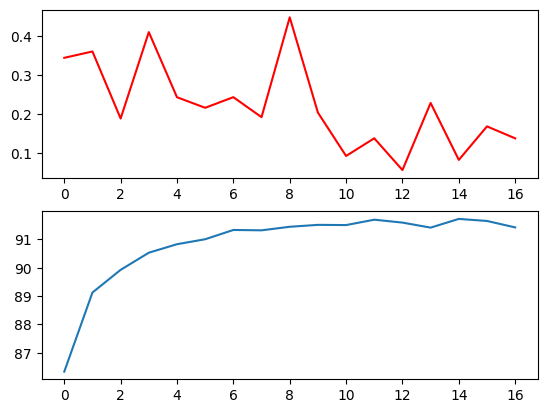

In [84]:
import seaborn as sns
accuracy_list = [acc.cpu().numpy() for acc in accuracy_list]

plt.subplot(2,1,1)
plt.plot(loss_list,label='loss',color='r')
plt.subplot(2,1,2)
plt.plot(accuracy_list, label='accuracy')

baseline 모델을 확인했을 때 accuracy가 점점 줄어드는 모습을 보이기 때문에 학습이 제대로 되고 있지 않는다고 볼 수 있다.

- 15 / 0.005 : 91.2 / 90.8
- 7 / 0.001 : 91.1 / 91.1
- 7 / 0.0005: 90.8 / 91.5

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

epoch의 수와 learning rate의 값만을 단순히 바꾼 뒤 제대로 된 학습을 하게 만들 경우를 비교해보면 vanila rnn의 성능이 LSTM과 GRU에 비해 떨어진다는 것을 알 수 있었다. 다만 LSTM과 GRU 간의 큰 차이는 확인할 수 없었다.